In [1]:
#Imports 
import numpy as np 
import matplotlib.pyplot as plt
import math 
import pandas as pd
from tqdm.notebook import tqdm
from numba import njit, prange

# DIAS Homework 6
## Ising model on a torus using Monte Carlo methods - Verify the analytical prediction for critical temperature

Simples lattice model of interacting magnetic spins. Torus is just a rectangle with periodic boundary conditions since it loops in on itself. 

In [2]:
#Functions of use 
#Hamiltonian 
@njit
def total_hamiltonian(J, spin_grid):
    energy=0
    N0=len(spin_grid)
    for ii in range(N0):
        for jj in range(N0):
            #Record the top and right adjacent entries only 
            #Periodic boundary conditions will allow this 
            #This stops double counting
            energy+=spin_grid[ii,jj]*spin_grid[int((ii+1)%N0) ,jj]
            energy+=spin_grid[ii,jj]*spin_grid[ii,int((jj+1)%N0)]
    energy*=-J
    return energy

#Lattice generator 
@njit
def lattice_generator(N):
    lattice=np.zeros((N,N))
    for ii in range(N):
        for jj in range(N):
            lattice[ii, jj]=(-1)**(np.random.randint(0,2))
    return lattice

#Function to return the average energy of the system for a given temperature
@njit
def average_energy(inv_beta, N, J, iterations):
    #Start with a randomised lattice of spins 
    #Generate array of random spin up/down particles
    spins_0=lattice_generator(N)
    
    #Store initial energy
    energy=np.zeros(iterations)
    energy[0]=total_hamiltonian(J, spins_0)
    
    for jj in range(1, iterations):
    #Track the iterations to make sure the simulation doesn't get stuck 
        track=0
        while energy[jj]==0:
            track+=1
            #Find a random location on the lattice
            location_x=np.random.randint(N)
            location_y=np.random.randint(N)
            #New array holds old value of spins
            spins_1=np.zeros((N,N))
            spins_1=spins_0.copy()
            #Flip the spin at the location
            spins_1[location_x, location_y]*=-1

            #Calculate the change in energy
            dE=total_hamiltonian(J, spins_1)-energy[jj-1]

            #Metropolis test 
            if np.exp(-dE/inv_beta)>np.random.uniform(0,1):
                #Becomes the new configuration for the spins
                spins_0=spins_1.copy()
                energy[jj]=total_hamiltonian(J, spins_0)

            #Break clause if loop gets stuck 
            elif track>=100:
                spins_0=spins_1.copy()
                energy[jj]=total_hamiltonian(J, spins_0)

    #Return the avergae energy
    return np.mean(energy)

In [3]:
#How many iterations 
iterations=int(1e6)

#Take coupling constant to be 1
J=1

#Initialise range of beta
db=0.1
inv_beta=np.arange(4.5, 1-db, -db)

In [4]:
#Main loops 
#N=2 loop 
eng_av_2=np.zeros(len(inv_beta))
for ii in tqdm(range(len(inv_beta))):
    eng_av_2[ii]=average_energy(inv_beta[ii], 2, J, iterations)

#N=4 loop 
eng_av_4=np.zeros(len(inv_beta))
for ii in tqdm(range(len(inv_beta))):
    eng_av_4[ii]=average_energy(inv_beta[ii], 4, J, iterations)
    
#N=8 loop
eng_av_8=np.zeros(len(inv_beta))
for ii in tqdm(range(len(inv_beta))):
    eng_av_8[ii]=average_energy(inv_beta[ii], 8, J, iterations)
    
#N=16 loop
eng_av_16=np.zeros(len(inv_beta))
for ii in tqdm(range(len(inv_beta))):
    eng_av_16[ii]=average_energy(inv_beta[ii], 16, J, iterations)

<IPython.core.display.Javascript object>


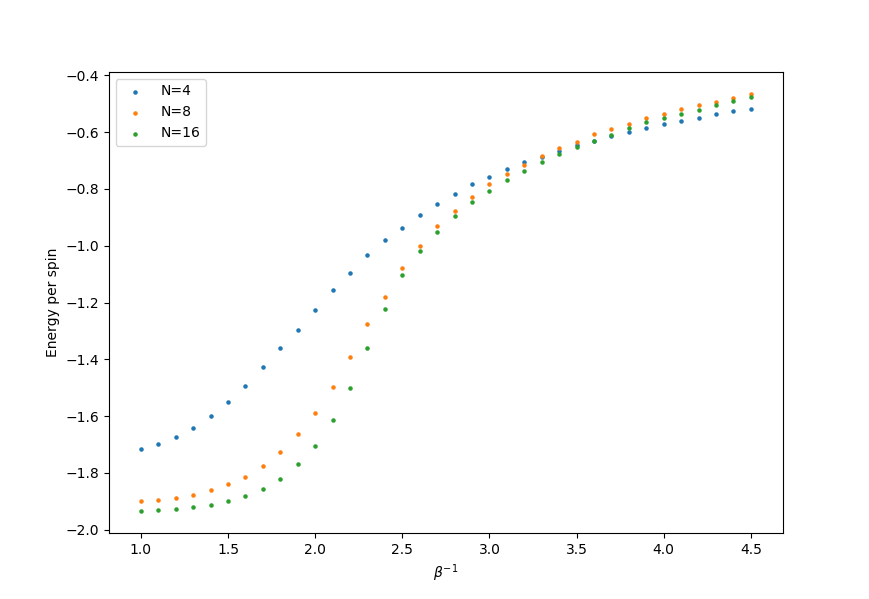

In [6]:
%matplotlib notebook
plt.scatter(inv_beta, (1/16)*eng_av_4, label='N=4', s=5)
plt.scatter(inv_beta, (1/(8*8))*eng_av_8, label='N=8', s=5)
plt.scatter(inv_beta, (1/(16**2))*eng_av_16, label='N=16', s=5)
plt.xlabel(r'$\beta^{-1}$')
plt.ylabel('Energy per spin')
plt.legend()